# Pythonによる画像解析ノート Vol. 1
これまでに書籍やWebで学んだ、Pythonによる顕微鏡画像解析や機械学習についてまとめておく。画像処理についてはImageJ/FIJIにおける操作と対比させる。

## 画像解析に使用するライブラリ
よく使うライブラリ
*  Numpy: 基本的な配列処理や数値計算。処理速度が速い。
*  Scipy: Numpyをさらに機能強化する。統計や信号解析が可能。
*  Pandas: データフレーム形式で様々なデータを加工する。
*  Matplotlib: データを可視化する。
*  Scikit-learn: Pythonで使用できる機械学習のライブラリ。
*  Scikit-image: Pythonで使用できる画像処理ライブラリ。
*  OpenCV: 画像や動画の処理・解析用ライブラリ。機械学習にも対応。

その他のライブラリ
*  Pillow: Python用の画像処理ライブラリ。OpenCVよりも軽量。
*  IPython:
*  tifffile: tiff形式のファイルの読み書き。ImageJ/FIJIのHyperstackファイルを読み書きできる。
*  nd2: Nikon nd2ファイルの読み込み。
*  imageio: 様々な形式のファイルの読み書き。

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
from PIL import Image as pilimage
from IPython.display import display, Image

## 画像の読み込みと表示
1. Pillowを使用する場合  
`Image.open()`で読み込む。作成されるオブジェクトはPillow固有の形式であり、Numpy配列ではない。

In [2]:
img = pilimage.open("images/001.jpg")
print("オブジェクトのtype:", type(img))
img.show() # デフォルトの画像表示アプリで表示
print("画像の形式:", img.format)

オブジェクトのtype: <class 'PIL.JpegImagePlugin.JpegImageFile'>
画像の形式: JPEG


In [3]:
img1 = np.asarray(img) # Numpy配列に変換できる

2. Matplotlibを使用する場合  
`mpimg.imread()`で読み込み。画像はNumpy配列に変換される。デフォルトでは8ビット画像（ピクセル値 0〜255）  
`plt.imshow()`で画像をインライン表示、カラー画像はそのまま表示される、グレースケールの場合はカラーマップ（cmap）を設定可能

オブジェクトのtype: <class 'numpy.ndarray'>
配列の次元数: 3
配列の形状: (454, 640, 3)


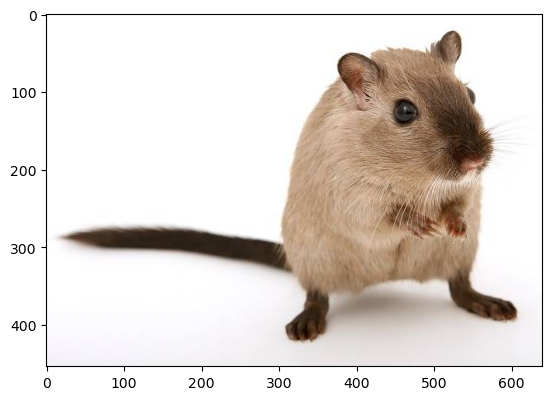

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread("images/001.jpg")
print("オブジェクトのtype:", type(img))
print("配列の次元数:", img.ndim)
print("配列の形状:", img.shape)
plt.imshow(img)

3. Scikit-imageを使用する場合  
`io.imread()`で読み込み。画像はNumpy配列に変換される。デフォルトでは8ビット画像（ピクセル値 0〜255）

In [9]:
from skimage import io, img_as_float, img_as_ubyte
img = io.imread("images/001.jpg")
print("オブジェクトのtype:", type(img))

オブジェクトのtype: <class 'numpy.ndarray'>


In [10]:
img_float = img_as_float(img) # 画像を、[0,1]の値を持つ浮動小数点形式に変換

4. OpenCVを使う場合  
`cv2.imread()`で読み込み。画像はNumpy配列に変換される。カラー画像を読み込む場合、RGBではなくBGR形式になることに注意。デフォルトでは8ビット画像（ピクセル値 0〜255）。  
第2引数で読み込むモードを様々に設定できる: https://qiita.com/yoya/items/b2fab73698d7aa35f5a7

In [11]:
import cv2
img = cv2.imread("images/001.jpg", 1) # 1がデフォルトでBGRで読み込み、0ではグレースケールで読み込む。
img2 = cv2.imread("images/dots_large.tif")

(454, 640, 3)

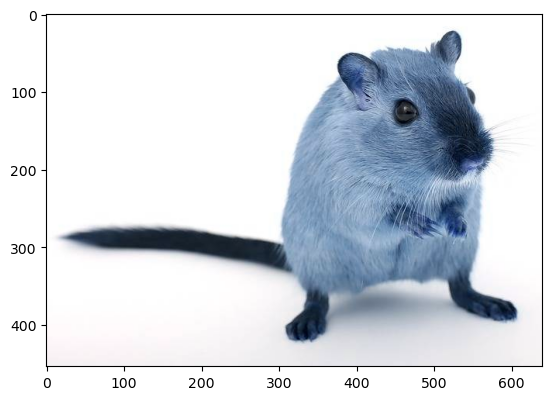

In [12]:
plt.imshow(img)
img.shape

画像を表示させるには`cv2.imshow()`があるが、Jupyter lab上では以下のように書かないとフリーズするので注意:

In [13]:
cv2.startWindowThread()
cv2.imshow("Image title", img)
# cv2.imshow("Image title", img) # 複数の画像を表示させることもできる
key = cv2.waitKey(0)
if key == ord('q'):            #qを押すと画像を閉じる
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

5. 画像をJupyter labのインラインで表示  
`plt.imshow()`以外にも`cv2.imencode()`と`IPython.display`を使用する方法がある。
参考:https://zenn.dev/jizai_labo/articles/230214_imshow

In [2]:
import cv2
from IPython.display import display, Image
_, buf = cv2.imencode(".jpg", img)
display(Image(data=buf.tobytes()))

NameError: name 'img' is not defined

In [3]:
# Jupyter notebookの中で画像を表示させるための関数
def show(img): 
    # print(img.shape)
    _, buf = cv2.imencode(".png", img) # メモリバッファに画像をエンコード（書き出し）
    # 戻り値は2つ、1番目は変換が成功したか否か（True/False）、不要なので_に格納
    # 2番目の戻り値がバイト列 buf、buf は uint8 型のNumpyのndarray
    display(Image(data=buf.tobytes()))
    return

In [4]:
# Jupyter notebookの中で画像を表示させるための関数、読み込んだ画像が16-bitならば画像を8bitに変換するように修正
def show(img_grey):
    if img_grey.dtype == "uint16":
        img_grey = cv2.normalize(img_grey, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    _, buf = cv2.imencode(".jpg", img_grey)
    print(type(buf))
    print(buf.shape)
    display(Image(data = buf.tobytes()))

## 顕微鏡画像の読み込み  
科学研究で使用する画像は基本的にtif形式。階調も8ビットではなく16ビット。また顕微鏡画像は複数の画像がまとめられたmulti-fiff画像であることが多い。  
ImageJのスタック画像やハイパースタック画像はcv2.imreadmulti関数で読み込み可能。  
1. 単一画像の読み込み

配列の次元数: 2
配列の形状: (292, 333)
要素のデータ型: uint16
最大のピクセル値: 16383
<class 'numpy.ndarray'>
(27644,)


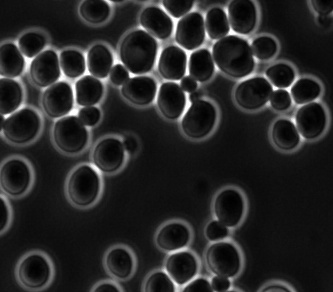

In [5]:
# グレースケール画像
img = cv2.imread("images/cell_16bit.tif", -1) # flag = 0 or 1だと8-bit画像として読み込まれるので、16-bit画像の場合は-1を指定
# img =cv2.imread("dots_large.tif", cv2.IMREAD_UNCHANGED) # こう書いても同じ、なるべく元の形式のまま読み込む 
print("配列の次元数:", img.ndim)
print("配列の形状:", img.shape)
print("要素のデータ型:", img.dtype)
print("最大のピクセル値:", img.max())
show(img)

配列の次元数: 3
配列の形状: (512, 512, 3)
要素のデータ型: uint8
最大のピクセル値: 255


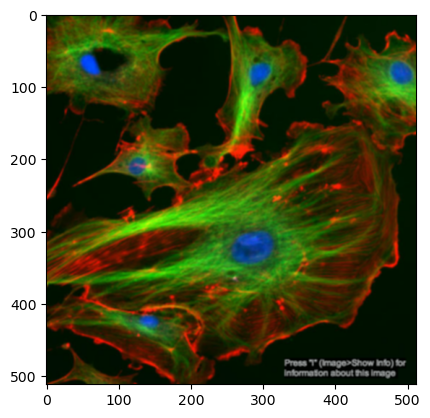

In [6]:
# 8bit RGB画像
# 3つ組のピクセル値 [R, G, B]が512✕512並んだndarrayとして表される
fcell = cv2.imread("images/FluorescentCells.tif", -1)
fcell = cv2.cvtColor(fcell, cv2.COLOR_BGR2RGB) # BGRで読み込むのでcvtColorでRGBに変換
print("配列の次元数:", fcell.ndim)
print("配列の形状:", fcell.shape)
print("要素のデータ型:", fcell.dtype)
print("最大のピクセル値:", fcell.max())
plt.imshow(fcell)

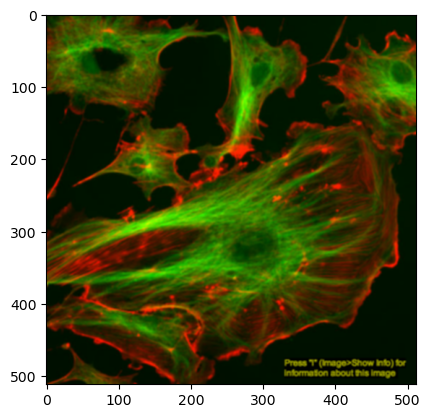

In [7]:
# 特定のチャンネルの色を消したい場合
fcell[:, :, 2]=0 # Blueの配列を全て0にする
plt.imshow(fcell)

In [8]:
# 3つのチャンネルに分解
fcell_r = fcell[:, :, 0]
fcell_g = fcell[:, :, 1]
fcell_b = fcell[:, :, 2]

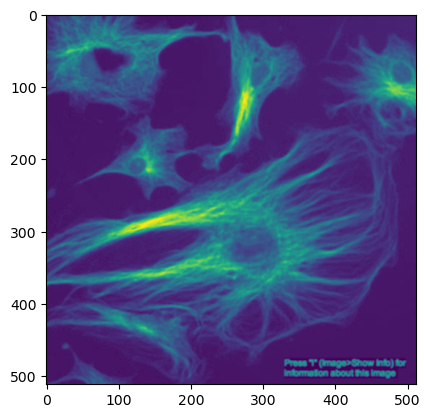

In [10]:
# リスト内包表記でそれぞれのチャンネルの画像をリストに格納
fcell_list = [fcell[:, :, i] for i in range(fcell.shape[2])]
plt.imshow(fcell_list[1])

In [ ]:
# cv2.split()を使ってチャンネルを分けることもできる
# 各チャンネルの画像がR, G, Bの順にタプルで格納される
fcell_chs = cv2.split(fcell)
# plt.imshow(fcell_chs[2]) # 青の画像を表示
show(fcell_chs[1]) # 緑の画像を表示

# RGBそれぞれの画像に分けることも可能、またmerge関数でカラー画像に戻すこともできる
r, g, b = cv2.split(fcell)
fcell_merge = cv2.merge((r, g, b))
plt.imshow(fcell_merge)

2. Multi-tiff画像の読み込み  
RGB各チャンネルのグレースケール画像を3枚含む場合、Zスタック画像、タイムラプス画像、およびそれらの組み合わせが考えられる。  
ImageJ/FIJIのHyperstackファイルに相当。
*  cv2.imreadmultiを使用  
返り値は2つで1つ目は読み込みの成否を表すだけなので捨てている。  
2つ目の返り値が複数画像をまとめたタプル。

In [3]:
# RGBチャンネルのグレースケール画像から構成されるmulti-tiff
_, chs = cv2.imreadmulti("images/3ch_image.tif", flags = -1)
print("読み込まれた画像の枚数:", len(chs))
print("配列の次元数:", chs[0].ndim)
print("配列の形状:", chs[0].shape)
print("要素のデータ型:", chs[0].dtype)

読み込まれた画像の枚数: 3
配列の次元数: 2
配列の形状: (415, 415)
要素のデータ型: uint16


In [ ]:
show(chs[0])

In [ ]:
show(chs[2])

In [ ]:
# タプルはndarrayに変換することができる
chs_arr = np.array(chs)
print("読み込まれた画像の枚数:", len(chs_arr))
print("配列の次元数:", chs_arr.ndim)
print("配列の形状:", chs_arr.shape)
print("要素のデータ型:", chs_arr.dtype)

In [ ]:
# multi-tiffをcv2.imread()で読み込むと、最初の画像のみが読み込まれる
chs2 = cv2.imread("images/3ch_image.tif", flags = -1)
show(chs2)
print("配列の次元数:", chs2.ndim)
print("配列の形状:", chs2.shape)
print("要素のデータ型:", chs2.dtype)

In [ ]:
# Zスタック画像の場合
_, stack = cv2.imreadmulti("images/mri-stack.tif", flags = -1)
print("読み込まれた画像の枚数:", len(stack))
print("配列の次元数:", stack[0].ndim)
print("配列の形状:", stack[0].shape)
print("要素のデータ型:", stack[0].dtype)

In [ ]:
show(stack[0])
show(stack[12])
show(stack[26])

In [ ]:
stack_arr = np.array(stack)
stack_arr.shape

読み込まれた画像の枚数: 15
配列の次元数: 4
配列の形状: (15, 130, 130, 3)
要素のデータ型: uint8
<class 'numpy.ndarray'>
(9541,)


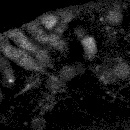

<class 'numpy.ndarray'>
(9995,)


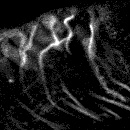

<class 'numpy.ndarray'>
(12505,)


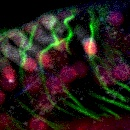

<class 'numpy.ndarray'>
(12613,)


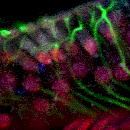

In [58]:
# RGB画像のzスタックの場合
# カラー画像✕15 zスライスでは4次元配列になる
_, cstack = cv2.imreadmulti("images/rgb_z15.tif", flags = -1)
cstack = np.array(cstack)
print("読み込まれた画像の枚数:", len(cstack))
print("配列の次元数:", cstack.ndim)
print("配列の形状:", cstack.shape)
print("要素のデータ型:", cstack.dtype)
show(cstack[0,:,:,0])
show(cstack[0,:,:,1])
show(cstack[0,:,:,:])
show(cstack[14,:,:,:])

読み込まれた画像の枚数: 60
配列の次元数: 3
配列の形状: (60, 249, 548)
要素のデータ型: uint16
<class 'numpy.ndarray'>
(31462,)


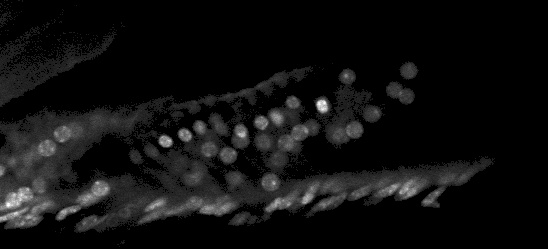

<class 'numpy.ndarray'>
(21561,)


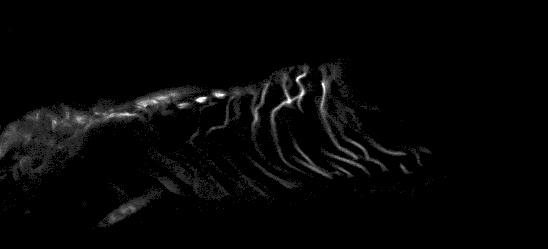

In [63]:
# 複数チャンネル、複数zスライスのmulti-tiff画像ではチャンネルとZスライスは同じ軸にまとめられる
# 例： 4チャンネル、15　zスライスの画像
# c1z1, c2z1, c3z1, ..., c4z15の順に並んでいる
# 配列の形状を(ch, z, x, y) = (4, 15, 249, 548)のように変換するには工夫が必要
_, stack = cv2.imreadmulti("images/organ-of-corti.tif", flags = -1)
stack = np.array(stack)
print("読み込まれた画像の枚数:", len(stack))
print("配列の次元数:", stack.ndim)
print("配列の形状:", stack.shape)
print("要素のデータ型:", stack.dtype)
show(stack[0, :, :])
show(stack[1, :, :])

(15, 4, 249, 548)
<class 'numpy.ndarray'>
(19347,)


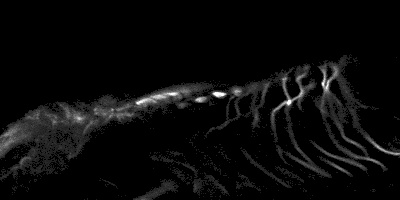

In [77]:
# 形状の変換を試みる、60枚の画像を15✕4枚組にすれば良い
stack1 = np.split(stack, 15, axis = 0) # np.splitは分割する個数と軸を指定
stack1 = np.array(stack1)
print(stack1.shape)
show(stack1[5,1,:200,:400])

(4, 249, 548)
<class 'numpy.ndarray'>
(24287,)


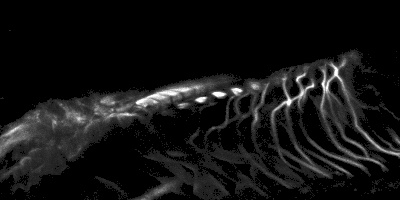

In [80]:
# Z方向のMax intensity projectionを作成
maxpro1 = np.max(stack1, axis=0)
print(maxpro1.shape)
show(maxpro1[1,:200,:400])

*  ライブラリtiffileを使用  
ImageJのhyperstackファイル画像を様々なメタデータと共に読み込むことが可能。    https://pypi.org/project/tifffile/

In [8]:
from tifffile import tifffile as tiff
chs = tiff.imread("images/3ch_image.tif")
print("読み込まれた画像の枚数:", len(chs))
print("配列の次元数:", chs.ndim)
print("配列の形状:", chs.shape)
print("要素のデータ型:", chs.dtype)

読み込まれた画像の枚数: 3
配列の次元数: 3
配列の形状: (3, 415, 415)
要素のデータ型: uint16


In [5]:
with tiff.TiffFile("images/3ch_image.tif") as f: # with構文でファイルを開くと様々なメタデータが抽出できる
    print("ファイル名:",f.filename)
    print("各次元の説明:", f.series[0].axes)
    tags = f.pages[0].tags
    ijmetadata = f.imagej_metadata

ファイル名: 3ch_image.tif
各次元の説明: CYX


In [6]:
# Voxel sizeとResolutionはimagej_metadataとtagsの情報から計算できる
# 複数のZスライスが含まれる場合はZResolutionも考慮に入れる
lengthunit = ijmetadata["unit"]
xresolution = tags["XResolution"].value[0]/tags["XResolution"].value[1]
yresolution = tags["YResolution"].value[0]/tags["YResolution"].value[1]
print("Unit of length:", lengthunit)
print(f"Resolution in X: {xresolution} pixels per {lengthunit}")
print(f"Resolution in Y: {yresolution} pixels per {lengthunit}")
print(f"Voxel size: {1/xresolution} x {1/yresolution} x 1 {lengthunit}^3")

Unit of length: micron
Resolution in X: 11.361111 pixels per micron
Resolution in Y: 11.361111 pixels per micron
Voxel size: 0.0880195607630275 x 0.0880195607630275 x 1 micron^3


In [7]:
# 4チャンネル、15　zスライスのhyperstack画像も正しく読み込むことが可能
hyperstack = tiff.imread("images/organ-of-corti.tif")
print("読み込まれた画像の枚数:", len(hyperstack))
print("配列の次元数:", hyperstack.ndim)
print("配列の形状:", hyperstack.shape)

読み込まれた画像の枚数: 15
配列の次元数: 4
配列の形状: (15, 4, 249, 548)


3. Nikon nd2ファイルの読み込み  
nd2ライブラリを使用すると、Nikon特有の画像データ形式であるnd2ファイルを直接読み込むことが可能。https://pypi.org/project/nd2/  
チャンネル、Zスライス、タイムポイント等が別の次元に分離された多次元numpy配列になる。  
撮影条件や観察条件等の情報も取得可能  
ただし「Unit of length」の情報は見つからなかった

In [2]:
import nd2
nd2_file_path = "/Users/masak_takaine/Desktop/test/nd1/Ade4_mNG_untreated_002.nd2"
nd2_arr =nd2.imread(nd2_file_path) # 画像をndarrayとして読み込み
print("読み込まれた画像の枚数:", len(nd2_arr))
print("配列の次元数:", nd2_arr.ndim)
print("配列の形状:", nd2_arr.shape)
print("要素のデータ型:", nd2_arr.dtype)

読み込まれた画像の枚数: 11
配列の次元数: 4
配列の形状: (11, 2, 1088, 1636)
要素のデータ型: uint16


In [13]:
with nd2.ND2File(nd2_file_path) as f: # with構文でファイルを開くと様々なメタデータが抽出できる
    print("ファイル名:", f.path)
    print("配列の次元数:", f.ndim)
    print("画像の形状:", f.sizes) # 各次元の説明と要素の個数
    print("RGB画像かどうか:", f.is_rgb)
    print("Voxel size in µm:", f.voxel_size())
    print(f"Resolution in X: {1/f.voxel_size().x} pixels per µm")
    text_info = f.text_info # 辞書形式の情報
    metadata = f.metadata
    attributes = f.attributes
    f.
    # arr2 = f.asarray() # nd_arrと同じndarrayが生成

ファイル名: /Users/masak_takaine/Desktop/test/nd1/Ade4_mNG_untreated_002.nd2
配列の次元数: 4
画像の形状: {'Z': 11, 'C': 2, 'Y': 1088, 'X': 1636}
RGB画像かどうか: False
Voxel size in µm: VoxelSize(x=0.146699266503666, y=0.146699266503666, z=0.5)
Resolution in X: 6.816666666666736 pixels per µm


In [4]:
print(text_info.keys())
# print(text_info["description"])
print(text_info["capturing"])
print(text_info["date"])
print(text_info["optics"])

dict_keys(['description', 'capturing', 'date', 'optics'])
Camera Nikon DS-Qi2
Sample 1:
  
  Camera Type: Nikon DS-Qi2
  Binning: 3.0x3.0
  Exposure: 400 ms
  Gain: 64.0x
  Trigger Mode: Internal
Sample 2:
  
  Camera Type: Nikon DS-Qi2
  Binning: 3.0x3.0
  Exposure: 300 ms
  Gain: 64.0x
  Trigger Mode: Internal
2022/10/25  14:06:30
Plan Apo λ 60x Oil Ph3 DM


<class 'numpy.ndarray'>
(4138,)


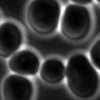

In [33]:
show(nd2_arr[5, 1, 0:100,0:100])

In [53]:
print(nd2_arr[:2, :2, :5,:5])
print(len(nd2_arr))

[[[[809 777 779 740 754]
   [807 810 834 821 823]
   [775 777 807 816 799]
   [814 802 779 784 798]
   [789 818 813 772 797]]

  [[  0   0   0   0   0]
   [  0   0   0   0   0]
   [  0   0   0   0   0]
   [  0   0   0   0   0]
   [  0   0   0   0   0]]]


 [[[715 633 629 576 703]
   [720 685 722 669 735]
   [673 688 719 688 681]
   [684 749 759 706 695]
   [776 835 783 727 744]]

  [[  0   0   0   0   0]
   [  0   0   0   0   0]
   [  0   0   0   0   0]
   [  0   0   0   0   0]
   [  0   0   0   0   0]]]]
11


In [51]:
# Zスライス11枚のMax intensity projectionを作成
maxpro = np.max(nd2_arr, axis = 0) # z-planeを表すaxis = 0の最大値を計算
print(maxpro.shape)

(2, 1088, 1636)


In [56]:
# 軸の順番を入れ替えたい場合
arr_trans = np.transpose(nd2_arr, (1, 0, 2, 3)) # 元の軸0と1を入れ替え
print(arr_trans.shape)

(2, 11, 1088, 1636)


<class 'numpy.ndarray'>
(4138,)


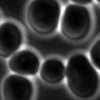

In [57]:
show(arr_trans[1, 5, 0:100,0:100])

### 画像のモンタージュ作成
グレースケールまたはのRGBの3次元画像の各画像を並べたndarrayを作成  

In [73]:
from skimage.util import montage
mitosis = tiff.imread("images/MAX_mitosis.tif")
print(mitosis.shape) # 51 frames, 2 channels
mitosis_ch1 = mitosis[:, 0, :, :]
mitosis_ch2 = mitosis[:, 1, :, :]
mitosis_ch1_eve3 = mitosis_ch1[0:47:4, :, :] # 0-47まで4フレーム毎に抽出
mitosis_ch2_eve3 = mitosis_ch2[0:47:4, :, :] # 0-47まで4フレーム毎に抽出
print(mitosis_ch1_eve3.shape)

(51, 2, 196, 171)
(12, 196, 171)


<class 'numpy.ndarray'>
(67544,)


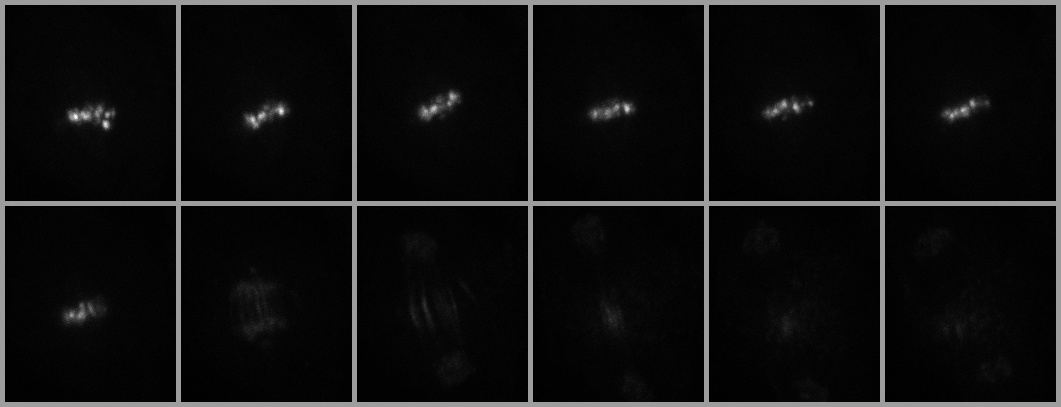

<class 'numpy.ndarray'>
(149103,)


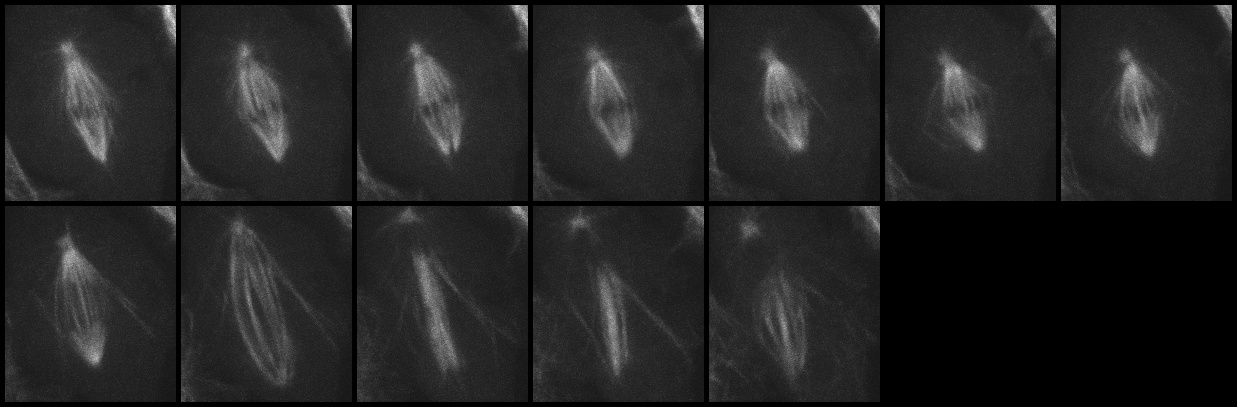

In [76]:
ch1_mon = montage(mitosis_ch1_eve3, fill = 30000, grid_shape=(2, 6), padding_width=5) # pading_widthは隙間、fillは隙間の明るさ
ch2_mon = montage(mitosis_ch2_eve3, fill = 0, grid_shape=(2, 7), padding_width=5) # pading_widthは隙間、fillは隙間の明るさ
show(ch1_mon)
show(ch2_mon)

<class 'numpy.ndarray'>
(127984,)


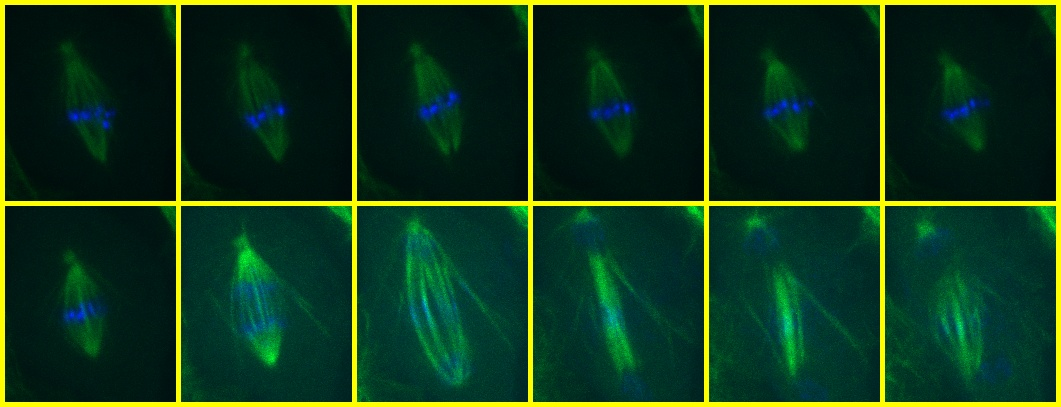

In [158]:
# マージしてカラーで表示
merge = np.zeros((12, 196, 171, 2)) # ブランクのndarrayを作成、(frames, y, x, color)
merge[:, :, :, 0] = mitosis_ch1_eve3
merge[:, :, :, 1] = mitosis_ch2_eve3
ch1_mon1 = montage(blank, fill = [0,255,255], rescale_intensity=True, grid_shape=(2, 6), padding_width=5, channel_axis=3) # channel_axisはshapeの何番目の次元が色を表すかを指定
show(ch1_mon1*255)

## 画像の保存
1. 単一画像の保存  
OpenCVの`cv2.imwrite()`を使用。ファイルの保存先のパスと画像オブジェクトを指定。パスの拡張子によって自動的にフォーマットが決まる。

In [84]:
import cv2
img = cv2.imread("images/001.jpg", 1) # 1がデフォルトでBGRで読み込み、0ではグレースケールで読み込む。
cv2.imwrite("images/saved001.png", img)
cv2.imwrite("images/saved001.tif", img)
cv2.imwrite("images/saved001.jpg", img, [cv2.IMWRITE_JPEG_QUALITY, 30]) # Qualityは0〜100、デフォルトは95

True

2. Multi-page tif画像の保存  
ライブラリ`tifffile`を使用してImageJ/FIJIのHyperstack画像に保存。メタデータを一緒に記録することができる。 https://pypi.org/project/tifffile/

In [188]:
# ex., Write a 10 fps time series of volumes with xyz voxel size 2.6755x2.6755x3.9474 micron^3 to an ImageJ hyperstack formatted TIFF file
volume = np.random.randn(6, 57, 256, 256).astype('float32')
image_labels = [f'{i}' for i in range(volume.shape[0] * volume.shape[1])]
tiff.imwrite(
     'temp.tif',
     volume,
     imagej=True,
     resolution=(1./2.6755, 1./2.6755),
     metadata={
        'spacing': 3.947368,
         'unit': 'um',
         'finterval': 1/10,
         'fps': 10.0,
       'axes': 'TZYX',
         'Labels': image_labels,
             })

3. フォルダ内の複数画像からスタックtiff画像を作成する場合  
https://github.com/bnsreenu/python_for_microscopists/blob/master/121_image_registration_using_pystackreg.py

In [ ]:
import glob
import tifffile

with tifffile.TiffWriter('images/my_image_stack.tif') as stack:
    for filename in glob.glob('images/for_alignment/*.tif'):
        stack.save(tifffile.imread(filename))

4. あるフォルダに存在する複数のnd2ファイルを読み込み、Max projection、チャンネルを分離してチャンネル毎にまとめたImageJ hyperstackファイルを作成

In [15]:
import numpy as np
import scipy as sp
import pandas as pd
import glob
import nd2
import os
from tifffile import tifffile as tiff
import cv2

In [17]:
folderS = "/Users/masak_takaine/210625_ade4GFP/nd"
# folderS = "/Users/masak_takaine/210625_ade4GFP/nd_test"
folderD = "/Users/masak_takaine/210625_ade4GFP/nd_test_results"
date = "2023-08-13"
file_list = glob.glob(folderS + "/*") #フォルダ内の全てのfile/folderのリストを取得して、ソートしておく
file_list.sort(reverse=True) 

# 各ファイルの名前、voxel sizeオブジェクトおよび分離した画像を格納するリスト
fname_list = []
vsize_list =[]
ch0_list = []
ch1_list = []

for path in file_list:
    filename = os.path.basename(path).split(".")[0]
    nd2_arr =nd2.imread(path) # 画像をndarrayとして読み込み
    with nd2.ND2File(path) as f: # with構文でファイルを開くと様々なメタデータが抽出できる
        vsize = f.voxel_size() # 
    img0 = np.max(nd2_arr, axis = 0) # Max intensity projection, z-planeを表すaxis = 0の最大値を計算
    h, w = img0.shape[1], img0.shape[2]
    img0_ch0 = img0[0,:,:].reshape(1, h, w) # (frame, y, x)に次元変更
    img0_ch1 = img0[1,:,:].reshape(1, h, w)
    
#     各リストに格納
    fname_list.append(filename)
    ch0_list.append(img0_ch0)
    ch1_list.append(img0_ch1)
    vsize_list.append(vsize)

#     vstackでリスト内の画像を1つ目の軸にまとめる
ch0_stack = np.vstack(ch0_list)
ch1_stack = np.vstack(ch1_list)

# 観察中に解像度が変更されることは無いので、最初のvsizeだけ使用
vsize0 = vsize_list[0]
reso = (1/vsize0.x, 1/vsize0.y)
tiff.imwrite(os.path.join(folderD,
     'ch0_stack.tif'),
     ch0_stack,
     imagej=True,
     resolution= reso,
     metadata={
        # 'spacing': 3.947368,
         'unit': 'um',
         # 'finterval': 1/10,
         # 'fps': 10.0,
       'axes': 'TYX',
         'Labels': fname_list,
             })
tiff.imwrite(os.path.join(folderD,
     'ch1_stack.tif'),
     ch1_stack,
     imagej=True,
     resolution= reso,
     metadata={
        # 'spacing': 3.947368,
         'unit': 'um',
         # 'finterval': 1/10,
         # 'fps': 10.0,
       'axes': 'TYX',
         'Labels': fname_list,
             })